In [1]:
import numpy as np
import util
import pickle
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import scipy.stats

/Users/Matthew/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
seed=229
state = np.random.RandomState(seed)

trainfile = 'data/train.csv'
header, ids, X, Y = util.fetch_data(trainfile)

test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=state)

# Training: Randomized Search
Use 10% of the data to conduct a search over XGBoost parameters, then test 

In [ ]:
best_xgb = None

try:
    best_xgb = pickle.load(open('models/xgb_randomized.pickle'))
except IOError:
    pass 

In [ ]:
m_search = X_train.shape[0]/3
X_paramsearch = X_train[:m_search,:]; Y_paramsearch = y_train[:m_search]

param_distros = {'learning_rate': scipy.stats.uniform(loc=0.01,scale=0.19),
                 'min_child_weight': scipy.stats.uniform(loc=0.1,scale=0.9),
                 'max_depth': scipy.stats.binom(n=10, p=0.6), 
                 'subsample': scipy.stats.uniform(loc=0.5,scale=0.5),
                 'colsample_bytree': scipy.stats.uniform(loc=0.5, scale=0.5),
                 'missing': [-1] # Treat -1's as missing
                }

xgb = XGBClassifier(silent=0, missing=-1)
cv_random = RandomizedSearchCV(xgb, n_iter=200, param_distributions=param_distros,
                               scoring=util.gini_proba_scorer, verbose=2, n_jobs=-1)
cv_random.fit(X_paramsearch, Y_paramsearch)

best_xgb_score = (-float('inf') if best_xgb == None 
                  else util.gini_proba_scorer(best_xgb, X_paramsearch, Y_paramsearch)) 

# Update best estimator
if cv_random.best_score_ > best_xgb_score: 
    best_xgb = cv_random.best_estimator_

xgb_out = open('models/xgb_randomized.pickle', 'wb')
pickle.dump(best_xgb, xgb_out)
xgb_out.close()

# Evaluation

In [3]:
best_xgb = pickle.load(open('models/xgb_randomized.pickle'))
print(best_xgb)

XGBClassifier(base_score=0.5, colsample_bylevel=1,
       colsample_bytree=0.79563799424128823, gamma=0,
       learning_rate=0.12525666963231602, max_delta_step=0, max_depth=4,
       min_child_weight=0.44883846042060982, missing=-1, n_estimators=100,
       nthread=-1, objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=0, subsample=0.52573466458954354)


In [4]:
trainsizes, traingini, testgini = util.learning_curves(best_xgb, X_train, X_test, y_train, y_test,
                                                      scorer=util.gini_proba_scorer)

Evaluating model on training set size 23808
Evaluating model on training set size 47616
Evaluating model on training set size 71425
Evaluating model on training set size 95233
Evaluating model on training set size 119042
Evaluating model on training set size 142850
Evaluating model on training set size 166659
Evaluating model on training set size 190467
Evaluating model on training set size 214276
Evaluating model on training set size 238084
Evaluating model on training set size 261892
Evaluating model on training set size 285701
Evaluating model on training set size 309509
Evaluating model on training set size 333318
Evaluating model on training set size 357126
Evaluating model on training set size 380935
Evaluating model on training set size 404743
Evaluating model on training set size 428552
Evaluating model on training set size 452360
Evaluating model on training set size 476169


In [5]:
print(traingini)
print('')
print(testgini)

[0.74933674358615487, 0.59523173037661359, 0.52433032373992905, 0.48087232778787109, 0.44588862666836543, 0.42558690212668182, 0.40236807338800107, 0.3986333309177949, 0.38205923259710656, 0.37442806942010332, 0.3657812151515944, 0.36036182284919649, 0.35813157378007765, 0.35226453760426341, 0.34805828900811048, 0.3421621847981281, 0.33996021421744865, 0.34362023321284951, 0.33687326891636199, 0.33323836350383457]

[0.16989634565794007, 0.18913373811593798, 0.21047509253322019, 0.22939890662015516, 0.23635397818903783, 0.23716346570145119, 0.24742610752989075, 0.25041068521626458, 0.24574343013112276, 0.250577050035236, 0.25320087990621676, 0.25219063876625258, 0.25798960221653228, 0.25469293447712171, 0.25594208609647318, 0.25939895276588859, 0.26190200051046952, 0.26179301468250155, 0.26264161582262563, 0.26164407657142669]


In [6]:
plt.figure()
plt.plot(trainsizes, traingini, label='train gini')
plt.plot(trainsizes, testgini, label='test gini')
plt.xlabel('Training set size')
plt.ylabel('Normalized Gini coefficient')
plt.title('XGBoost with RandomizedSearchCV')
plt.legend()
plt.savefig('figures/learning_curves/xgboost_randomized.eps')

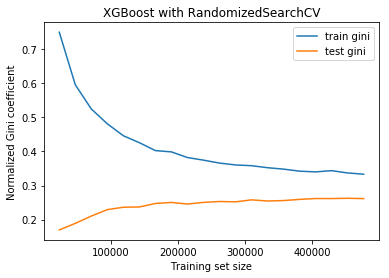

In [7]:
plt.show()

# Output

In [ ]:
best_xgb.fit(X, Y)
print(util.gini_proba_scorer(best_xgb, X, Y))

In [ ]:
util.make_prediction(best_xgb, 'data/test.csv', 'predictions/xgboost_randomized_171213_01.csv',
                     predict_method=util.proba_method(best_xgb))